## Loading and Preprocessing the Dataset

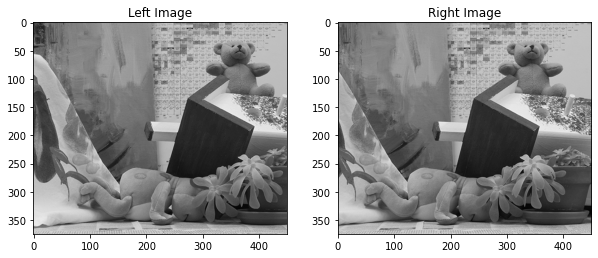

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images
left_img = cv2.imread(r'C:\Users\Aadii\Downloads/left2.png', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(r'C:\Users\Aadii\Downloads/right2.png', cv2.IMREAD_GRAYSCALE)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.title('Left Image')
plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.title('Right Image')
plt.show()


##  Feature Detection and Description

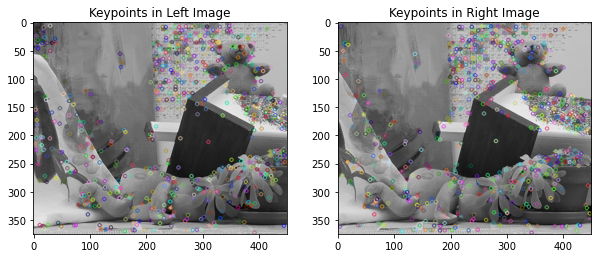

In [51]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect and compute features
keypoints_left, descriptors_left = sift.detectAndCompute(left_img, None)
keypoints_right, descriptors_right = sift.detectAndCompute(right_img, None)

# Draw keypoints
left_img_keypoints = cv2.drawKeypoints(left_img, keypoints_left, None)
right_img_keypoints = cv2.drawKeypoints(right_img, keypoints_right, None)

# Display keypoints
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_img_keypoints)
plt.title('Keypoints in Left Image')
plt.subplot(1, 2, 2)
plt.imshow(right_img_keypoints)
plt.title('Keypoints in Right Image')
plt.show()


##  FLANN-based matcher for feature matching.

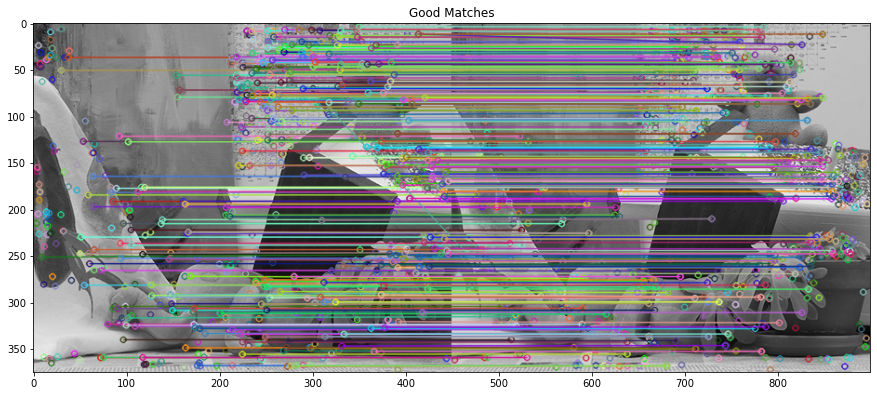

In [52]:
# FLANN-based matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
matches_img = cv2.drawMatches(left_img, keypoints_left, right_img, keypoints_right, good_matches, None)

# Display matches
plt.figure(figsize=(15, 10))
plt.imshow(matches_img)
plt.title('Good Matches')
plt.show()


##  Camera Pose Estimation

Rotation Matrix:
 [[ 9.99981330e-01 -7.12182281e-04 -6.06896344e-03]
 [ 7.13287668e-04  9.99999729e-01  1.79975160e-04]
 [ 6.06883363e-03 -1.84300716e-04  9.99981567e-01]]
Translation Vector:
 [[-0.9974324]
 [-0.0138369]
 [-0.0702648]]


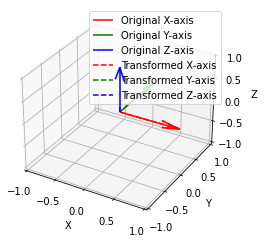

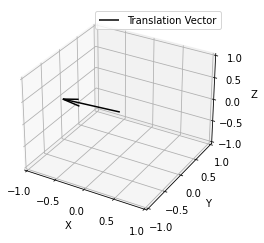

In [56]:
# Extract location of good matches
points_left = np.zeros((len(good_matches), 2), dtype=np.float32)
points_right = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points_left[i, :] = keypoints_left[match.queryIdx].pt
    points_right[i, :] = keypoints_right[match.trainIdx].pt

# Camera intrinsic parameters (assuming fx = fy, cx, cy are the same for both images)
fx = 1000  # Focal length in x-axis
fy = 1000  # Focal length in y-axis
cx = left_img.shape[1] / 2  # Principal point x-coordinate
cy = left_img.shape[0] / 2  # Principal point y-coordinate
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

# Compute essential matrix
E, mask = cv2.findEssentialMat(points_left, points_right, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Recover relative camera pose
_, R, t, mask = cv2.recoverPose(E, points_left, points_right, K)

print("Rotation Matrix:\n", R)
print("Translation Vector:\n", t)
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# Assuming R and t are your rotation matrix and translation vector respectively

# Function to plot the rotation matrix
def plot_rotation_matrix(R):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Original axis
    origin = np.array([[0, 0, 0]]).T
    x_axis = np.array([[1, 0, 0]]).T
    y_axis = np.array([[0, 1, 0]]).T
    z_axis = np.array([[0, 0, 1]]).T
    
    # Transformed axis
    x_axis_transformed = R @ x_axis
    y_axis_transformed = R @ y_axis
    z_axis_transformed = R @ z_axis
    
    # Plot original axes
    ax.quiver(*origin, *x_axis, color='r', label='Original X-axis')
    ax.quiver(*origin, *y_axis, color='g', label='Original Y-axis')
    ax.quiver(*origin, *z_axis, color='b', label='Original Z-axis')
    
    # Plot transformed axes
    ax.quiver(*origin, *x_axis_transformed, color='r', linestyle='dashed', label='Transformed X-axis')
    ax.quiver(*origin, *y_axis_transformed, color='g', linestyle='dashed', label='Transformed Y-axis')
    ax.quiver(*origin, *z_axis_transformed, color='b', linestyle='dashed', label='Transformed Z-axis')
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Function to plot the translation vector
def plot_translation_vector(t):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    origin = np.array([[0, 0, 0]]).T
    translation_vector = t
    
    ax.quiver(*origin, *translation_vector, color='k', label='Translation Vector')
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Plot the rotation matrix
plot_rotation_matrix(R)

# Plot the translation vector
plot_translation_vector(t)



## Error Metrics

In [57]:
# Assuming ground truth rotation and translation (R_gt, t_gt)
R_gt = np.eye(3)  # Replace with actual ground truth rotation matrix
t_gt = np.array([0, 0, 1])  # Replace with actual ground truth translation vector

# Compute rotation error
rotation_error = np.linalg.norm(R - R_gt)

# Compute translation error
translation_error = np.linalg.norm(t - t_gt)

print("Rotation Error:", rotation_error)
print("Translation Error:", translation_error)


Rotation Error: 0.00864558199125459
Translation Error: 2.857108366047098


## Bonus: Detecting and Removing Moving Actors

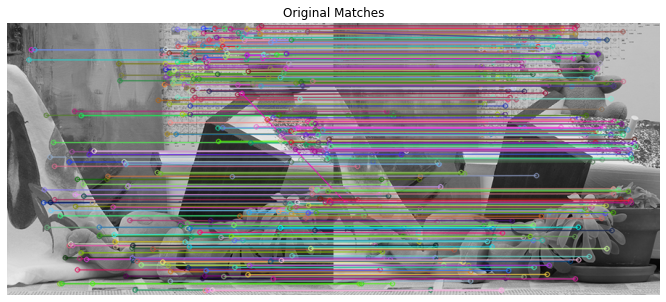

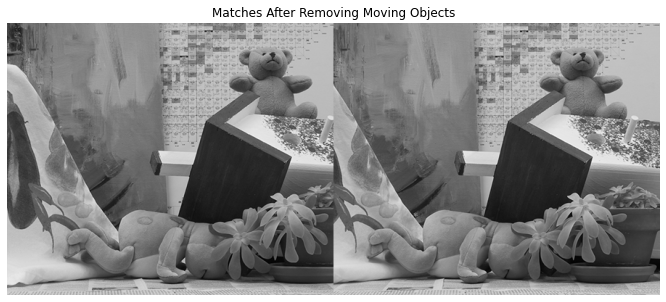

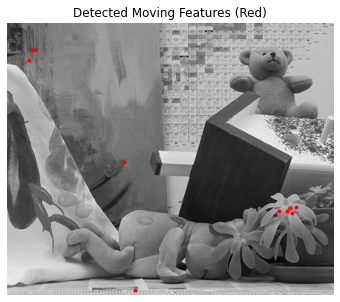

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_moving_features(img1, img2, kp1, kp2, matches):
    # Create background subtractor
    fgbg = cv2.createBackgroundSubtractorMOG2()
    
    # Apply background subtraction on both images
    fgmask1 = fgbg.apply(img1)
    fgmask2 = fgbg.apply(img2)
    
    # Convert keypoints to numpy arrays
    prev_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    next_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Calculate optical flow
    flow, status, _ = cv2.calcOpticalFlowPyrLK(img1, img2, prev_pts, next_pts)
    
    # Calculate flow magnitude
    flow_magnitude = np.linalg.norm(flow - prev_pts, axis=2)
    
    # Threshold for considering a point as moving
    threshold = np.mean(flow_magnitude) + np.std(flow_magnitude)
    
    # Filter out moving points based on optical flow
    static_matches = [m for i, m in enumerate(matches) if flow_magnitude[i] < threshold]
    
    # Further filter static matches by checking if they are within the foreground mask
    static_matches_final = []
    for m in static_matches:
        pt1 = kp1[m.queryIdx].pt
        pt2 = kp2[m.trainIdx].pt
        if fgmask1[int(pt1[1]), int(pt1[0])] == 0 and fgmask2[int(pt2[1]), int(pt2[0])] == 0:
            static_matches_final.append(m)
    
    return static_matches_final, flow_magnitude < threshold

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
    plt.figure(figsize=(15,5))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load images
left_img_path =r'C:\Users\Aadii\Downloads/left2.png'  # Replace with your actual image path
right_img_path = r'C:\Users\Aadii\Downloads/right2.png'  # Replace with your actual image path

left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

# Check if images are loaded correctly
if left_img is None:
    print(f"Error: Unable to load image at {left_img_path}")
elif right_img is None:
    print(f"Error: Unable to load image at {right_img_path}")
else:
    sift = cv2.SIFT_create()
    keypoints_left, descriptors_left = sift.detectAndCompute(left_img, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(right_img, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_left, descriptors_right, k=2)

    # Apply Lowe's ratio test to get good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Visualize original matches
    visualize_matches(left_img, keypoints_left, right_img, keypoints_right, good_matches, 'Original Matches')

    # Remove moving features
    static_matches, static_mask = remove_moving_features(left_img, right_img, keypoints_left, keypoints_right, good_matches)

    # Visualize static matches
    visualize_matches(left_img, keypoints_left, right_img, keypoints_right, static_matches, 'Matches After Removing Moving Objects')

    # Visualize flow magnitude
    plt.figure(figsize=(10,5))
    plt.imshow(left_img, cmap='gray')
    for i, m in enumerate(good_matches):
        if not static_mask[i]:
            pt = keypoints_left[m.queryIdx].pt
            plt.plot(pt[0], pt[1], 'ro', markersize=3)
    plt.title('Detected Moving Features (Red)')
    plt.axis('off')
    plt.show()
